In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
img_size = 256
bat_size = 32
channels = 3 #rgb
epochs = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = bat_size
)

Found 20638 files belonging to 15 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)     #gives the no. of batches

645

In [6]:
for im_batch, label_batch in dataset.take(1):
    print(im_batch.shape)

(32, 256, 256, 3)


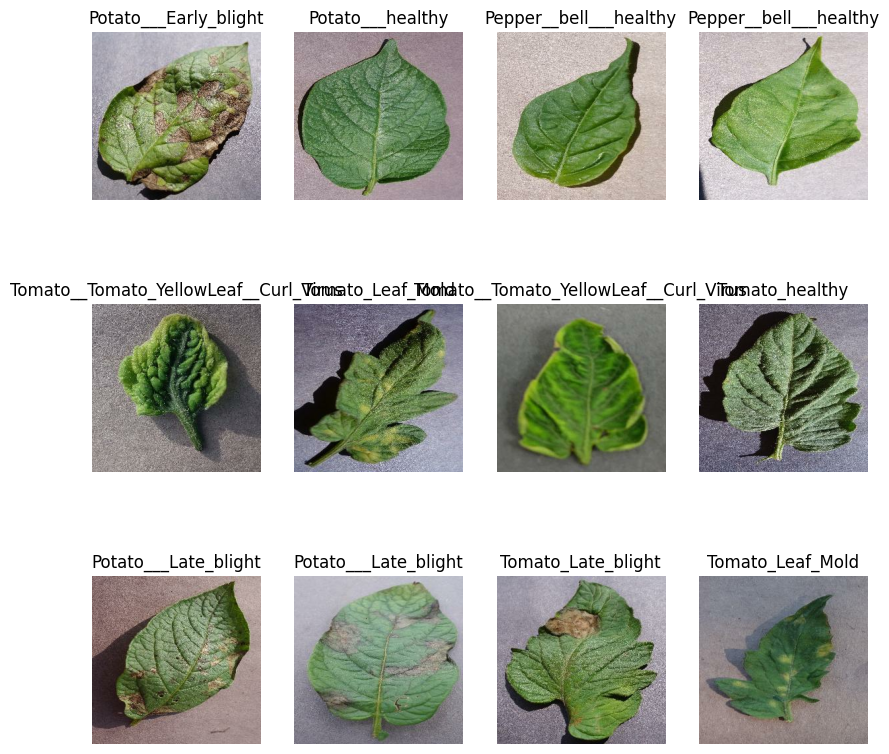

In [7]:
plt.figure(figsize=(10, 10))
for im_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(im_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#train test split--80% train, 20%test---> 10%validation,10%test 
# whole dataset = 68 epoch
train_size = int(0.8*len(dataset))
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
validation_ds = test_ds.take(int(0.5*len(test_ds)))
test_ds = test_ds.skip(len(validation_ds))

In [9]:
len(validation_ds)

64

In [10]:
def get_ds_partitions(ds, train=0.8, val=0.1, test=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train*ds_size)
    train_ds = ds.take(train_size)
    val_size = int(val*ds_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [11]:
train_ds, val_ds, test_ds = get_ds_partitions(dataset)

In [12]:
len(test_ds)

65

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
resize_and_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [42]:
#_____________________we are going to go inside the video of building the model__________________________________

In [16]:
input_shape = (bat_size, img_size, img_size, channels)
number_of_classes = 15


model = models.Sequential([
    resize_and_rescaling,
    augmentation,
    layers.Conv2D(32, (3, 3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax'),
])



model.build(input_shape = input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs = epochs,
    batch_size=bat_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
516/516 [==============================] - 871s 2s/step - loss: 2.2213 - accuracy: 0.2652 - val_loss: 1.8062 - val_accuracy: 0.4053
Epoch 2/50
516/516 [==============================] - 783s 2s/step - loss: 1.5602 - accuracy: 0.4818 - val_loss: 1.3992 - val_accuracy: 0.5293
Epoch 3/50
516/516 [==============================] - 792s 2s/step - loss: 1.0432 - accuracy: 0.6538 - val_loss: 1.0565 - val_accuracy: 0.6396
Epoch 4/50
516/516 [==============================] - 842s 2s/step - loss: 0.7523 - accuracy: 0.7410 - val_loss: 0.8088 - val_accuracy: 0.7061
Epoch 5/50
516/516 [==============================] - 781s 2s/step - loss: 0.5833 - accuracy: 0.7967 - val_loss: 0.6674 - val_accuracy: 0.7812
Epoch 6/50
516/516 [==============================] - 746s 1s/step - loss: 0.4956 - accuracy: 0.8249 - val_loss: 0.7481 - val_accuracy: 0.7583
Epoch 7/50
516/516 [==============================] - 824s 2s/step - loss: 0.4282 - accuracy: 0.8523 - val_loss: 0.5951 - val_accuracy: 0.8018

In [20]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 73s 309ms/step - loss: 0.1048 - accuracy: 0.9591


In [21]:
scores

[0.10475611686706543, 0.9591346383094788]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 516}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
history.history['accuracy']

[0.26520106196403503,
 0.4817708432674408,
 0.6538275480270386,
 0.7410368323326111,
 0.7966933250427246,
 0.8248546719551086,
 0.8522892594337463,
 0.8664607405662537,
 0.8788759708404541,
 0.8859617114067078,
 0.893713653087616,
 0.8978318572044373,
 0.9095203280448914,
 0.908490777015686,
 0.9155765771865845,
 0.9209060072898865,
 0.925266444683075,
 0.9276283979415894,
 0.9313226938247681,
 0.9332001209259033,
 0.9361676573753357,
 0.9330183863639832,
 0.9376816749572754,
 0.9430111646652222,
 0.9429506063461304,
 0.945009708404541,
 0.945009708404541,
 0.9527616500854492,
 0.9503996968269348,
 0.9493095874786377,
 0.9535489082336426,
 0.9468871355056763,
 0.9519743323326111,
 0.9571826457977295,
 0.9576671719551086,
 0.9548207521438599,
 0.9609980583190918,
 0.9577277302742004,
 0.958696722984314,
 0.9592417478561401,
 0.964026153087616,
 0.9597868323326111,
 0.9604530334472656,
 0.965661346912384,
 0.9597262740135193,
 0.9626332521438599,
 0.9632993936538696,
 0.9655402302742004,

In [26]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

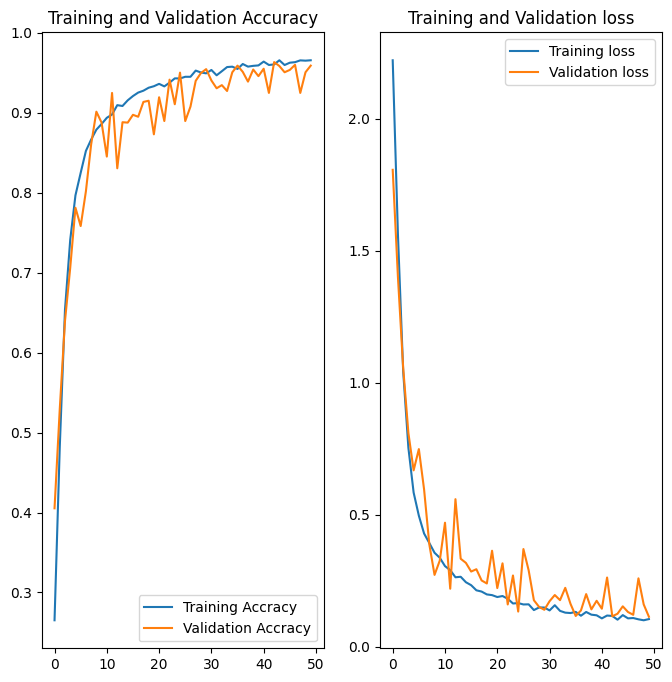

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), accuracy, label = "Training Accracy")
plt.plot(range(epochs), validation_accuracy, label = "Validation Accracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label = "Training loss")
plt.plot(range(epochs), validation_loss, label = "Validation loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation loss")

first image to predict: 
first image's actual label:  Tomato_Spider_mites_Two_spotted_spider_mite
1/1 [==============================] - 0s 200ms/step
Predicted label is  Tomato_Spider_mites_Two_spotted_spider_mite


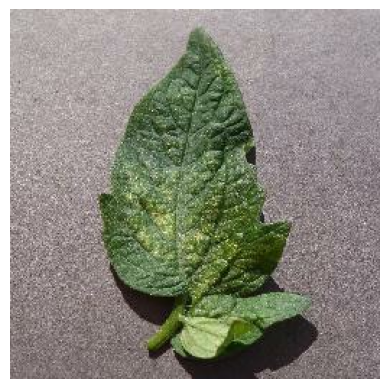

In [29]:
#for making a prediction
import numpy as np
for im_batch, label_batch in test_ds.take(1):
    first_image = im_batch[0].numpy().astype("uint8")
    first_label = class_names[label_batch[0].numpy()]
    
    print("first image to predict: ")
    plt.imshow(first_image)
    plt.axis("off")
    print("first image's actual label: ", first_label)
    
    batch_prediction = model.predict(im_batch)
    print("Predicted label is ",class_names[np.argmax(batch_prediction[0])])

In [30]:
# defining a prediction function

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)#create a batch
    
    img_prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(img_prediction[0])]
    confidence = round(100*(np.max(img_prediction[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


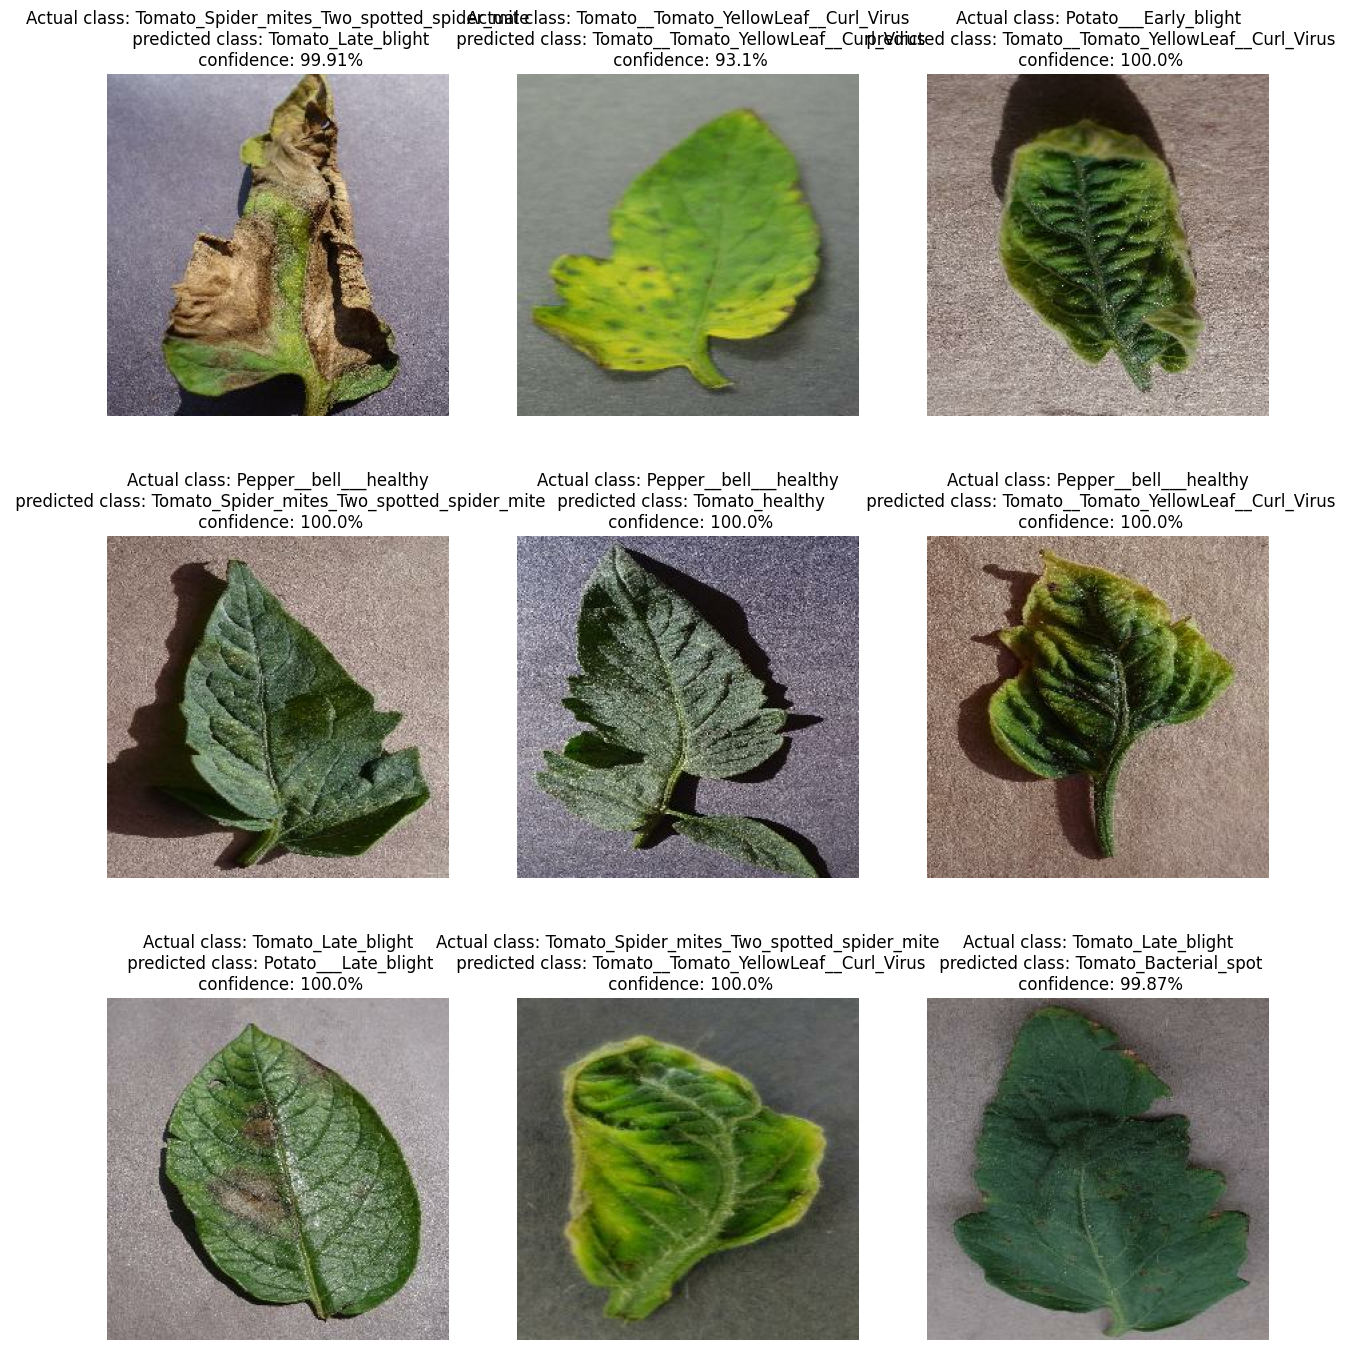

In [36]:
plt.figure(figsize=(15, 17))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[label_batch[i].numpy()]
        plt.title(f"Actual class: {actual_class}\n predicted class: {predicted_class}\n confidence: {confidence}%")
        plt.axis("off")

In [37]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [ ]:
#_____________to make change in the model architecture and then save it in a new version _____________

model_version=max([int(i) for i in os.listdir("../models/") + [0]])+1
model.save(f"../models/{model_version}")